In [1]:
import pandas as pd

from protrend.utils import NeoDatabase, Settings

In [2]:
neo_db = NeoDatabase(user_name=Settings.db_user_name, password=Settings.db_password,
                     ip=Settings.db_ip, port=Settings.db_port)
neo_db.connect()

In [3]:
dfs = []
labels = ['Effector',
          'Evidence',
          'Gene',
          'Operon',
          'Organism',
          'Pathway',
          'Publication',
          'Regulator',
          'RegulatoryFamily',
          'RegulatoryInteraction',
          'TFBS']
for label in labels:
    res = neo_db.db.cypher_query(f"match(s:Source)-[]-(t:{label}) return s.name, count(distinct(t.protrend_id))")
    df = pd.DataFrame(res[0], columns=['Source', 'Objects'])
    dfs.append(df)

In [4]:
df = pd.concat(dfs, keys=labels).reset_index(drop=False)
df = df.drop(columns=['level_1'])
df

,level_0,Source,Objects
0,Effector,regprecise,308
1,Effector,bsub_faria_et_al_2017,140
2,Effector,regulondb,68
3,Gene,collectf,1972
4,Gene,regprecise,101945
5,Gene,abasy,8184
6,Gene,coryneregnet,3848
7,Gene,bsub_faria_et_al_2017,1844
8,Gene,ecol_fang_et_al_2017,2190
9,Gene,mtub_turkarslan_et_al_2015,774


In [5]:
data = pd.pivot_table(df, values='Objects', index=['level_0'], columns=['Source'])
data = data.fillna(0)
data['Literature'] = data['bsub_faria_et_al_2017'] + data['ecol_fang_et_al_2017'] + data['mtub_turkarslan_et_al_2015']
data = data.drop(columns=['bsub_faria_et_al_2017', 'ecol_fang_et_al_2017', 'mtub_turkarslan_et_al_2015'])
data['total'] = data.sum(axis=1)
data = data.div(data.total, axis=0) * 100
data = data.rename(index={'RegulatoryFamily': 'R.Fam', 'RegulatoryInteraction': 'Interaction'})
data.index.name = 'Entity'
data.columns = ['Abasy', 'CollecTF', 'CoryneRegNet', 'DBTBS', 'ODB', 'RegPrecise', 'RegulonDB', 'Literature', 'Total']
data = data.drop(columns=['Total'])
data

,Abasy,CollecTF,CoryneRegNet,DBTBS,ODB,RegPrecise,RegulonDB,Literature
Entity,,,,,,,,
Effector,0.000000,0.000000,0.000000,0.000000,0.000000,59.689922,13.178295,27.131783
Gene,5.906893,1.423313,2.777337,0.483580,9.470227,73.579935,2.888488,3.470227
Operon,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
Organism,0.881057,15.418502,0.587372,0.146843,9.691630,72.687225,0.146843,0.440529
Pathway,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
Regulator,3.209294,1.259562,3.071260,0.626905,0.000000,87.691954,1.104273,3.036752
R.Fam,0.000000,0.000000,0.000000,0.900901,0.000000,76.576577,22.522523,0.000000
Interaction,5.175238,1.159865,4.113745,0.532119,0.000000,78.293832,5.208638,5.516563
TFBS,0.000000,2.357092,5.514894,1.207321,0.000000,84.398654,6.522038,0.000000


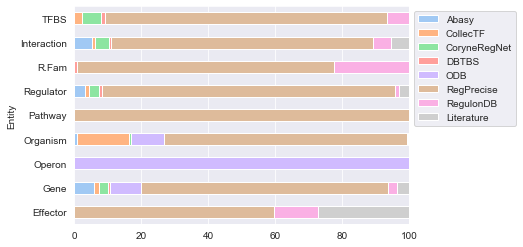

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
data.plot.barh(stacked=True, color=sns.color_palette('pastel').as_hex())

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.xlim(0, 100)

plt.savefig("source_report.png", bbox_inches="tight", dpi=150)
plt.show()